In [ ]:
username = 'acp23vst'

In [ ]:
# import some modules

import assignment
import numpy as np
import matplotlib.pyplot as plt

# The Problem

Ecologists have monitored the population of Haggis on a particular mountain for five years. They have precise recordings (see `xtrue` and `ytrue`) and estimates from satellite remote sensing (`xdata` and `ydata`). They want to be able to *forecast* the *true population*, 12 months into the future.

In [ ]:
xdata,ydata,xtrue,ytrue = assignment.data()

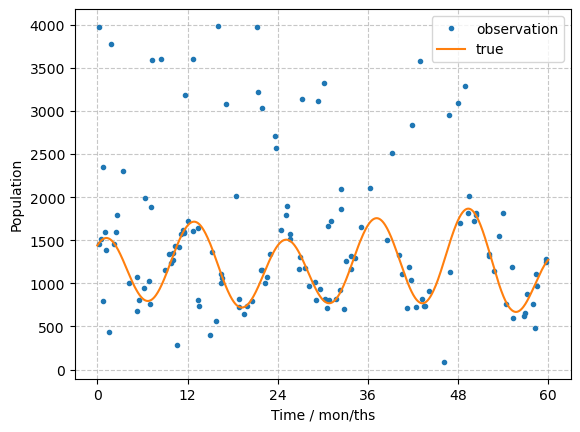

In [ ]:
plt.plot(xdata,ydata,'.',label='observation')
plt.plot(xtrue,ytrue,'-',label='true')
plt.xticks(np.arange(0,61,12))
plt.xlabel('Time / mon/ths')
plt.ylabel('Population')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

### Task 1

When developing your model for this problem, how could you split your data into training, validation and testing? (and why?) [max 30 words]

In [ ]:
explanation_q1 = """
I would random split the data into training (70-80%), validation (10-15%), and testing (10-15%) sets.
Training data for model learning, validation for fine-tuning of hyperparameters and testing for unbiased performance assessment.
"""

assignment.wc(explanation_q1)

30 words


### Task 2: Gaussian Basis

In lab 4 you used a polynomial basis. The answer was of the form:

```
def polynomial(x, num_basis=4, data_limits=[-1., 1.]):
    Phi = np.zeros((x.shape[0], num_basis))
    for i in range(num_basis):
        Phi[:, i:i+1] = x**i
    return Phi
```    
    
For this question, write a new function that creates a **Gaussian basis**.

Each basis function is of the form, $\exp[-\frac{(x-c)^2}{2w^2}]$. Where `c` is the centre of each Gaussian basis, and $w$ is a constant (hyperparameter) that says how wide they are. You will want to space them uniformly across the domain specified by `data_limits`. So if `data_limits = [-2, 4]` and `num_basis = 4`. The centres will be at, -2 0 2 4.

Note: For now **we'll not have a constant term** (this will be ok if you standardise your data, as the mean will be zero).

In [ ]:
def gaussian(x, num_basis=4, data_limits=[-1., 1.], width = 10):
    """
    Return an N x D design matrix.
    Arguments:
     - x, input values (N dimensional vector)
     - num_basis, number of basis functions (specifies D)
     - data_limits, a list of two numbers, specifying the minimum and maximum of the data input domain.
     - width, the 'spread' of the Gaussians in the basis
    """

    # Ensure whether x is a column vector to maintain consistent format for subsequent operations.
    x = x.reshape(-1, 1)

    # Generate evenly spaced centers within the data_limits.
    basis_function_centers = np.linspace(data_limits[0], data_limits[1], num_basis)

    # Initialize empty basis matrix (N x D)
    Phi = np.zeros((x.shape[0], num_basis))

    # Calculate and populate basis matrix with Gaussian basis function values
    for index in range(num_basis):

        # Calculate the Gaussian basis function value for each input data point
        # And assign them to the corresponding column in Phi.
        Phi[:, index:(index + 1)] = np.exp(-0.5 * ((x - basis_function_centers[index]) / width) ** 2)
    return Phi


assignment.checkQ2(gaussian)

Success


### Task 3: Ordinary Least Squares Regression

Rather than compute the closed form solution we will compute the gradient and use gradient descent for ridge regression (L2 regularisation).

First, write a function to compute the gradient of the sum squared error wrt a parameter vector w. Given it has L2 regularisation (with regularisation parameter $\lambda$).

To get you started, here is the $L2$ regularised cost function:

$$E = (y - \Phi w)^\top  (y - \Phi w) + \lambda w ^ \top w$$

In [ ]:
def grad_ridge(Phi,y,w,lam):
    """
    Return an D dimensional vector of gradients of w, assuming we want to minimise the sum squared error
    using the design matrix in Phi; under ridge regression with regularisation parameter lambda.
    Arguments:
     - Phi, N x D design matrix
     - y, training outputs
     - w, parameters (we are finding the gradient at this value of w)
     - lam, the lambda regularisation parameter.
    """

    # Calculate the predicted outputs
    y_prediction = np.dot(Phi, w)

    # Calculate the gradient of the sum squared error wrt w
    error = (y_prediction - y)              # Calculate the difference between the predicted and true targets
    gradientE_w = 2 * np.dot(Phi.T, error)  # The gradient of the data fitting term

    # Add the L2 regularization gradient
    gradientE_w += 2 * lam * w              # The gradient of the regularization term

    return gradientE_w.T  # Gradient is transposed for easier usage in gradient descent


assignment.checkQ3(grad_ridge)

Success


This `grad_descent` function uses gradient descent to minimise the cost function (optimise using an appropriate learning rate).

In [ ]:
def grad_descent(grad_fn,Phi,y,lam):
    """
    Compute optimised w.
    Parameters:
       - grad, the gradient function
       - Phi, design matrix (shape N x D)
       - y, vector of observations (length N)
       - lam, regularisation parameter, lambda.
    Returns
       - w_optimsed, a vector (length D) that minimises the ridge regression cost function
    """
    w = np.zeros(Phi.shape[1])
    for it in range(10000):
        g = grad_fn(Phi,y,w,lam)
        w-=0.0001*g
    return w

### Let's see how we're doing...

In this code I standardise the training data labels, and use the methods you have written to make predictions for all the `true` data. Note that I'm holding out the last 12 months to see how the model looks for forecasting. I've also not used any validation, but instead have just used fixed value of the hyperparameters.

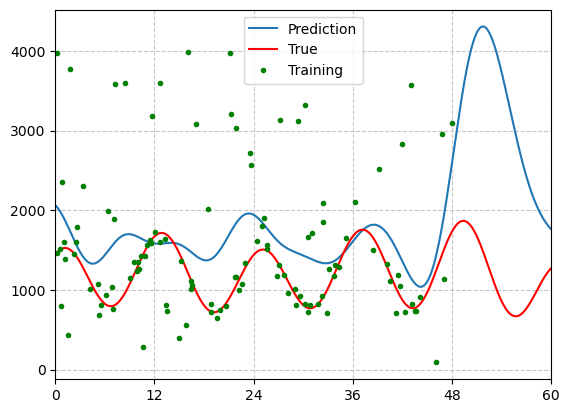

In [ ]:
import matplotlib.ticker as ticker

xtrain = xdata[xdata<48]
ytrain = ydata[xdata<48]
xval = xtrue[xtrue>=48]
yval = ytrue[xtrue>=48]

data_mean = np.mean(ytrain)
data_std = np.std(ytrain)
ytrain_standardised = (ytrain - data_mean)/data_std

Phi = gaussian(xtrain,120,[0,60],3)
w = grad_descent(grad_ridge,Phi,ytrain_standardised,0.01)
truePhi = gaussian(xtrue,120,[0,60],3)
plt.plot(xtrue,(truePhi @ w)*data_std+data_mean,label='Prediction')
plt.plot(xtrue,ytrue,'-r',label='True')
plt.plot(xtrain,ytrain,'.g',label='Training')
plt.legend()
plt.xticks(np.arange(0, 61, 12))    # Representing the x-axis, data in 12 months.
plt.xlim([0,60])
plt.grid(True, linestyle='--', alpha=0.7)

There are two more tasks to do:

1) handle the outliers
2) Use a better basis

### Task 4

Let's use the sum of absolute errors, rather than the sum squared error, as the cost function. We will also keep the L2 regulariser. So the cost function can be:

$$E = \sum_{i=1}^N{ \Big| [\Phi]_{i} w - y_i \Big|} + \lambda w^\top w$$

Write down a function that computes the gradient of this function wrt w.

In [ ]:
def grad_abs(Phi,y,w,lam):
    """
    Return an D dimensional vector of gradients of w, assuming we want to minimise the sum absolute error
    using the design matrix in Phi; under L2 regularisation parameter lambda.
    Arguments:
     - Phi, N x D design matrix
     - y, training outputs
     - w, parameters (we are finding the gradient at this value of w)
     - lam, the lambda regularisation parameter.
    """

    # Calculate the gradient of the sum absolute error wrt w
    prediction_error = Phi.dot(w) - y  # Calculate the difference between the predicted and true targets

    # Calculate the absolute error vector
    absolute_error_vector = np.sign(prediction_error)

    # Compute the regularized gradient
    regularized_gradient = 2 * lam * w
    regularized_gradient += Phi.T @ absolute_error_vector

    return regularized_gradient


assignment.checkQ4(grad_abs)

Success


Let's see what the result looks like, using the absolute error:

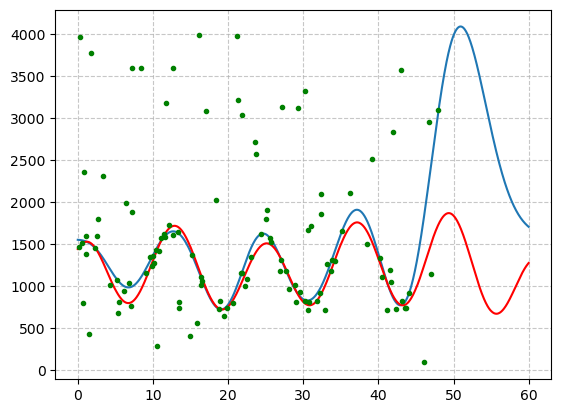

In [ ]:
Phi = gaussian(xtrain,120,[0,60],3)
w = grad_descent(grad_abs,Phi,ytrain_standardised,0.01)
truePhi = gaussian(xtrue,120,[0,60],3)
plt.plot(xtrue,(truePhi @ w)*data_std+data_mean,label='Prediction')
plt.plot(xtrue,ytrue,'-r',label='True')
plt.plot(xtrain,ytrain,'.g',label='Training')
plt.grid(True, linestyle='--', alpha=0.7)

### Task 5

Comment on this result in terms why this result appears better than the sum-squared cost function

In [ ]:
q5 = """
Model's lower SAE compared to SSE implies its superior ability to mitigate the impact of outliers and
noisy data, making it a more suitable metric for models trained on such datasets
"""


assignment.wc(q5)

30 words


### Task 6

To improve its ability to forecast we observe that there seems to be an annual oscillation in the data. Can you create a basis that combines both Gaussian bases *AND* sinusoidal bases *of the appropriate wavelength*. Please use half of the `num_basis` for the Gaussian bases, and the other half for the sinusoidal ones. All the sinusoidal bases should have a 12 month period, but with a range of offsets (uniformly distributed between 0 and 6, but not including 6).

In [ ]:
def gaussian_and_sinusoidal(x, num_basis=4, data_limits=[-1., 1.], width=10):
    """
    Return an N x D design matrix. Arguments:
    - x, input values (N dimensional vector)
    - num_basis, number of basis functions (specifies D)
    - data_limits, a list of two numbers, specifying the minimum and maximum of the data input domain. - width, the 'spread' of the Gaussians in the basis
    Half the bases are Gaussian, half are evenly spaced cosines of 12 month period (offset by between 0 to 6 months) """

    # Initialize the design matrix
    design_matrix = np.zeros((x.shape[0], num_basis))

    # Calculate Gaussian basis functions
    num_gaussian_basis = num_basis // 2
    gaussian_centers = np.linspace(data_limits[0], data_limits[1], num_gaussian_basis)

    for i in range(num_gaussian_basis):

        # Evaluate Gaussian basis functions and assign to the corresponding column in Phi
        design_matrix[:, i] = np.exp(-0.5 * ((x - gaussian_centers[i]) / width) ** 2)

    # Calculate Sinusoidal basis functions
    num_sinusoidal_basis = num_basis - num_gaussian_basis

    for j in range(num_sinusoidal_basis):

        # Calculate the offset for each sinusoidal basis
        offset = (6 / num_sinusoidal_basis) * j

        # Evaluate sinusoidal basis functions and assign to the corresponding column in Phi
        design_matrix[:, num_gaussian_basis + j] = np.cos(2 * np.pi * (x / 12) + offset)

    return design_matrix


Let's see how this has affected the result:

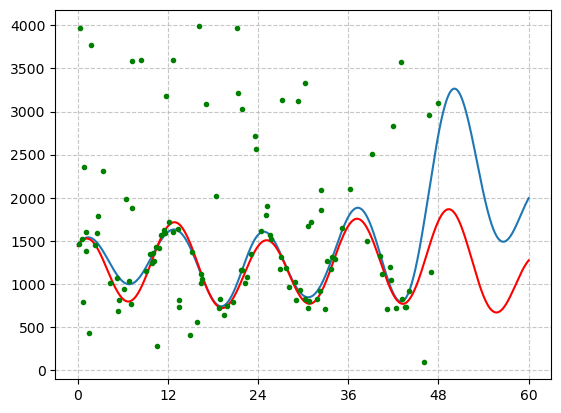

In [ ]:
Phi = gaussian_and_sinusoidal(xtrain,120,[0,60],3)
w = grad_descent(grad_abs,Phi,ytrain_standardised,0.01)
truePhi = gaussian_and_sinusoidal(xtrue,120,[0,60],3)
plt.plot(xtrue,(truePhi @ w)*data_std+data_mean,label='Prediction')
plt.xticks(np.arange(0,61,12))
plt.plot(xtrue,ytrue,'-r',label='True')
plt.plot(xtrain,ytrain,'.g',label='Training')
plt.grid(True, linestyle='--', alpha=0.7)

### Task 7

We now need to select the parameters.

Write some code that:
- Selects good parameters
- Draws a graph of the result

For this question you will need to:
- Decide on how you will select:
    - an appropriate number of bases
    - an appropriate Gaussian basis width
    - an appropriate regularisation term
- (you might want to use a validation set)
- Decide how you will split your data into training and validation. You could use the approach we used at the end of Q3. Remember: You are given the true underlying function, in `xtrue` and `ytrue`, so it is a comparison with that which matters. Remember also that you want to do well at **forecasting**!
- Plot a graph showing (a) the training points used; (b) the true population (`truex`, `truey`); and (c) your predictions.

Best Parameters: {'num_bases': 200, 'width': 9, 'lam': 0.02}


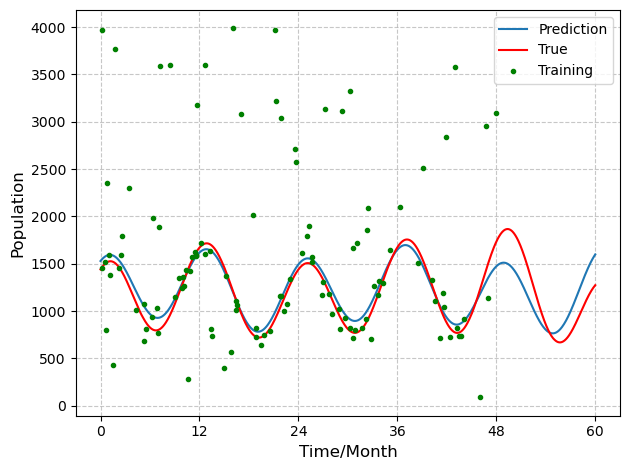

In [ ]:
# Making my own dataset
my_xtrain = xdata[xdata < 48]
my_ytrain = ydata[xdata < 48]
my_xvalidation = xtrue[xtrue >= 48]
my_yvalidation = ytrue[xtrue >= 48]

# Standardizing training data
my_data_mean = np.mean(my_ytrain)
my_standardised_data = np.std(my_ytrain)
standardised_ytrain_data = (ytrain - my_data_mean) / my_standardised_data

# Define combinations of hyperparameters to search through
num_bases_val = [50, 100, 150, 200]
width_val = [1, 3, 5, 7, 9, 10]
lam_val = [0.02, 0.01, 0.1]

my_combinations = [(n, w, l) for n in num_bases_val for w in width_val for l in lam_val]

# Initialize variables to track errors and best parameters
e1 = float('inf')
choosing_best_parameters = {}

# Iterate through combinations to find the best parameters
for num_bases, width, lam in my_combinations:
    # Generate the feature matrix using Gaussian and Sinusoidal functions
    Phi = gaussian_and_sinusoidal(my_xtrain, num_bases, [0, 60], width)

    # Apply gradient descent to find the weights minimizing the loss function
    w = grad_descent(grad_abs, Phi, standardised_ytrain_data, lam)

    # Generate features for validation data
    truePhi = gaussian_and_sinusoidal(my_xvalidation, num_bases, [0, 60], width)

    # Calculate the absolute error between predicted and actual values on the validation set
    e2 = np.sum(np.abs((truePhi @ w) * my_standardised_data + my_data_mean - my_yvalidation))

    # Update best parameters if the current error is lower than the previous lowest error
    if e2 < e1:
        e1 = e2
        choosing_best_parameters = {'num_bases': num_bases, 'width': width, 'lam': lam}

# Print the best parameters
print(f'Best Parameters: {choosing_best_parameters}')

# Use the best parameters to generate features for training data and perform gradient descent
Phi = gaussian_and_sinusoidal(my_xtrain, choosing_best_parameters['num_bases'], [0, 60], choosing_best_parameters['width'])
w = grad_descent(grad_abs, Phi, standardised_ytrain_data, choosing_best_parameters['lam'])

# Generate features for the entire dataset
true_Phi = gaussian_and_sinusoidal(xtrue, choosing_best_parameters['num_bases'], [0, 60], choosing_best_parameters['width'])

# Plotting the predicted and actual values
predicted_values = (true_Phi @ w) * my_standardised_data + my_data_mean

plt.plot(xtrue, predicted_values, label='Prediction')
plt.plot(xtrue, ytrue, 'r-', label='True')
plt.plot(my_xtrain, my_ytrain, 'g.', label='Training')

# Set x-axis ticks
x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)

# Adding labels and legend
plt.legend()
plt.xlabel('Time/Month', fontsize=12)
plt.ylabel('Population', fontsize=12)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adjusting plot layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
# Functions:

def tune_hyperparameters(train_x, train_y, validation_x, validation_y, num_bases_values, width_values, lam_values):
    """
    Tune hyperparameters using a grid search approach.
    Arguments:
    - train_x (numpy.ndarray): Training data.
    - train_y (numpy.ndarray): Training data.
    - validation_x (numpy.ndarray): Validation data.
    - validation_y (numpy.ndarray): Validation data.
    - num_bases_values (list): List of values for the number of bases to try.
    - width_values (list): List of values for the width to try.
    - lam_values (list): List of values for the regularization parameter to try.

    Returns:
    - best_parameters (dict): Best hyperparameters found during the grid search.
    """
    # Initialize variables for tracking errors
    lowest_error = float('inf')
    best_parameters = {}

    # Generate combinations of hyperparameters
    hyperparameter_combinations = [(n, w, l) for n in num_bases_values for w in width_values for l in lam_values]

    # Loop through hyperparameter combinations
    for num_bases, width, lam in hyperparameter_combinations:
        # Generate feature matrix using Gaussian and Sinusoidal functions for training data
        train_phi = gaussian_and_sinusoidal(train_x, num_bases, [0, 60], width)

        # Apply gradient descent to find weights minimizing the loss function
        weights = grad_descent(grad_abs, train_phi, standardized_train_y, lam)

        # Generate feature matrix for validation set
        validation_phi = gaussian_and_sinusoidal(validation_x, num_bases, [0, 60], width)

        # Calculate absolute error between predicted and actual values on the validation set
        current_error = np.sum(np.abs((validation_phi @ weights) * train_std + train_mean - validation_y))

        # Update lowest error and best parameters if the current error is lower
        if current_error < lowest_error:
            lowest_error = current_error
            best_parameters = {
                'num_bases': num_bases,
                'width': width,
                'lam': lam
            }

    return best_parameters


In [ ]:
# Data Initialization
train_x = xdata[xdata < 48]
train_y = ydata[xdata < 48]
validation_x = xtrue[xtrue >= 48]
validation_y = ytrue[xtrue >= 48]

# Calculate mean and standard deviation for standardization
train_mean = np.mean(train_y)
train_std = np.std(train_y)

# Standardize the training data
standardized_train_y = (train_y - train_mean) / train_std

# Hyperparameter values to try
num_bases_values = [50, 100, 150, 200]
width_values = [1, 3, 5, 7, 9, 10]
lam_values = [0.02, 0.01, 0.1]


In [ ]:
# Use the best parameters to train the final model
best_parameters = tune_hyperparameters(
    train_x,
    my_ytrain,
    validation_x,
    validation_y,
    num_bases_values,
    width_values,
    lam_values
)

final_train_phi = gaussian_and_sinusoidal(
    train_x,
    best_parameters['num_bases'],
    [0, 60],
    best_parameters['width']
)

final_weights = grad_descent(
    grad_abs,
    final_train_phi,
    standardized_train_y,
    best_parameters['lam']
)

final_validation_phi = gaussian_and_sinusoidal(
    xtrue,
    best_parameters['num_bases'],
    [0, 60],
    best_parameters['width']
)


# Generate predictions for the validation set using the final model
predicted_values = (final_validation_phi @ final_weights) * train_std + train_mean

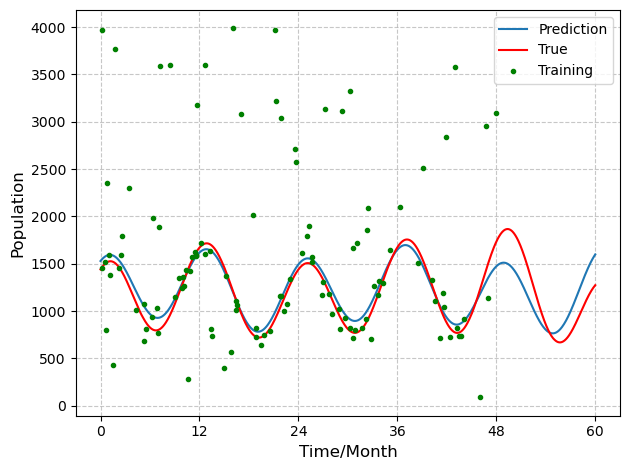

In [ ]:
# Plotting the results
plt.plot(xtrue, predicted_values, label = 'Prediction')
plt.plot(xtrue, ytrue, 'r-', label = 'True')
plt.plot(train_x, my_ytrain, 'g.', label = 'Training')

# Set x-axis ticks
x_ticks = np.arange(0, 61, 12)
plt.xticks(x_ticks)

# Add legend and labels
plt.legend()
plt.xlabel('Time/Month', fontsize=12)
plt.ylabel('Population', fontsize=12)

# Add grid
plt.grid(True, linestyle = '--', alpha = 0.7)

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()
